# Data description

In [1]:
# import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as stats

from collections import Counter

In [2]:
train = pd.read_csv("data/processed/train.csv")
test = pd.read_csv("data/processed/test.csv")

## Unique movies

In [3]:
common_ids = set(train['movie_id'].unique()) & set(test['movie_id'].unique())
count_common_ids = len(common_ids)

print(f"Number of unique id values that appear in both train and test: {count_common_ids}")

Number of unique id values that appear in both train and test: 12500


## Ratings

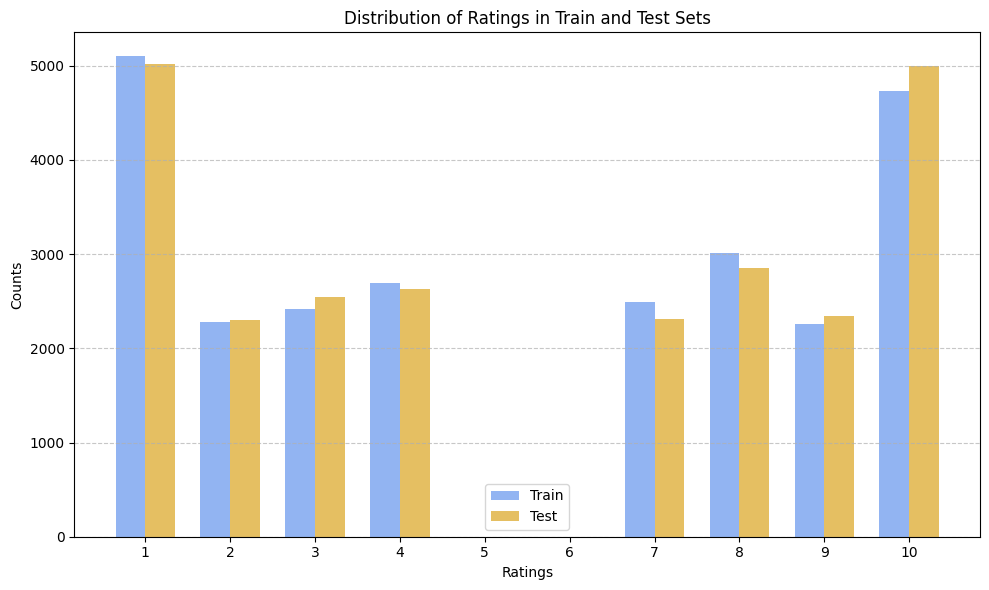

In [4]:
plt.figure(figsize=(10, 6))

ratings_range = range(1, 11)
x = np.array(ratings_range)
width = 0.35

train_counts = [train['rating'].value_counts().get(i, 0) for i in ratings_range]
test_counts = [test['rating'].value_counts().get(i, 0) for i in ratings_range]

plt.bar(x - width/2, train_counts, width, color='cornflowerblue', alpha=0.7, label='Train')
plt.bar(x + width/2, test_counts, width, color='goldenrod', alpha=0.7, label='Test')

plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Distribution of Ratings in Train and Test Sets')
plt.xticks(ratings_range)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Length

In [5]:
def get_text_stats(df):
    # Character length
    df['char_length'] = df['text'].apply(len)
    char_min = df['char_length'].min()
    char_max = df['char_length'].max()
    char_avg = df['char_length'].mean()
    
    # Word length
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    word_min = df['word_count'].min()
    word_max = df['word_count'].max()
    word_avg = df['word_count'].mean()
    
    return {
        'char_min': char_min,
        'char_max': char_max,
        'char_avg': round(char_avg, 0),
        'word_min': word_min,
        'word_max': word_max,
        'word_avg': round(word_avg, 0)
    }

train_stats = get_text_stats(train)
test_stats = get_text_stats(test)

comparison = pd.DataFrame({
    'Train': [train_stats['char_min'],
              train_stats['char_max'],
              train_stats['char_avg'],
              train_stats['word_min'],
              train_stats['word_max'],
              train_stats['word_avg']],
    'Test': [test_stats['char_min'],
             test_stats['char_max'],
             test_stats['char_avg'],
             test_stats['word_min'],
             test_stats['word_max'],
             test_stats['word_avg']]}, 
    index=['Min Characters',
          'Max Characters',
          'Avg Characters',
          'Min Words',
          'Max Words',
          'Avg Words'])

comparison.style.set_caption('Reviews Length Statistics').format("{:.0f}")

,Train,Test
Min Characters,52,32
Max Characters,13604,12730
Avg Characters,1305,1274
Min Words,10,4
Max Words,2459,2235
Avg Words,231,226


## Correlation

In [6]:
correlation, p_value = stats.pearsonr(train['rating'], train['word_count'])

print(f"Pearson correlation coefficient between ratings and reviews length: {correlation:.4f}")
print(f"Associated p-value: {p_value:.4f}")

Pearson correlation coefficient between ratings and reviews length: 0.0148
Associated p-value: 0.0193


In [7]:
word_count_stats = train.groupby('rating')['word_count'].agg(['mean', 'median', 'count'])
word_count_stats.style.set_caption('Word count statistics by rating')


Word count statistics by rating:


,mean,median,count
rating,,,
1,209.362353,160.000000,5100
2,223.788529,175.000000,2284
3,248.116942,187.000000,2420
4,250.983309,192.000000,2696
7,258.310096,201.000000,2496
8,249.900964,189.000000,3009
9,242.923111,176.000000,2263
10,208.063821,153.000000,4732


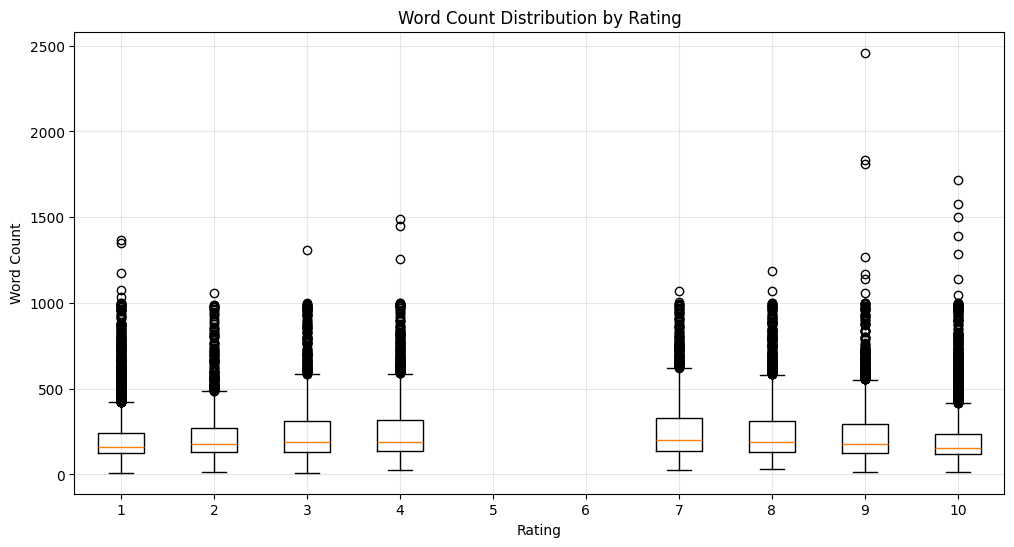

In [14]:
plt.figure(figsize=(12, 6))
plt.boxplot([train[train['rating'] == i]['word_count'] for i in range(1, 11)], 
            tick_labels=range(1, 11))
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.grid(True, alpha=0.3)
plt.show()